### A convolutional neural network (CNN) is a type of artificial neural network used primarily for image recognition and processing, due to its ability to recognize patterns in images. A CNN is a powerful tool but requires millions of labeled data points for training.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from google.colab import files
import warnings
import pydot
import graphviz
import gdown

warnings.filterwarnings('ignore', category=FutureWarning)
tf.get_logger().setLevel('ERROR')


In [2]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
!gdown --id 1YJK60VsmRm1qrnXoIGjk7CsQ-bk_vlX0 -O food_data.zip

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1YJK60VsmRm1qrnXoIGjk7CsQ-bk_vlX0
From (redirected): https://drive.google.com/uc?id=1YJK60VsmRm1qrnXoIGjk7CsQ-bk_vlX0&confirm=t&uuid=da4798c6-8f41-4207-8dee-3a937057be9b
To: /content/food_data.zip
100% 5.93G/5.93G [02:00<00:00, 49.0MB/s]


In [4]:
import zipfile

# Unzip the downloaded file. Takes some time
with zipfile.ZipFile('food_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/food_data')



In [5]:
import os
import random
import shutil
base_dir = '/content/food_data/food_images'
train_dir = '/content/food_data/train'
val_dir = '/content/food_data/validation'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Split the data into training and validation sets
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)
    if os.path.isdir(category_path):
        os.makedirs(os.path.join(train_dir, category), exist_ok=True)
        os.makedirs(os.path.join(val_dir, category), exist_ok=True)

        images = os.listdir(category_path)
        random.shuffle(images)

        split_index = int(0.8 * len(images))
        train_images = images[:split_index]
        val_images = images[split_index:]

        for img in train_images:
            shutil.move(os.path.join(category_path, img), os.path.join(train_dir, category))

        for img in val_images:
            shutil.move(os.path.join(category_path, img), os.path.join(val_dir, category))


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 83541 images belonging to 115 classes.
Found 20892 images belonging to 115 classes.


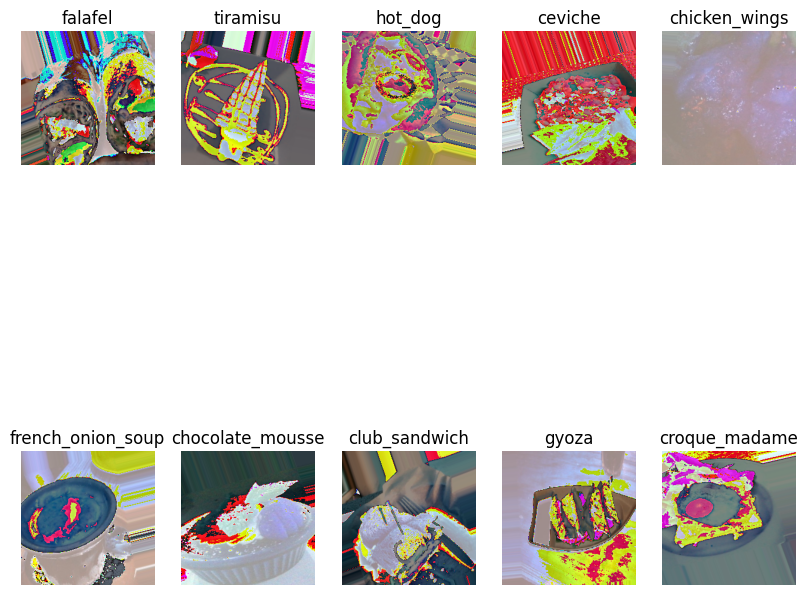

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Display random food images
class_names = list(train_generator.class_indices.keys())
images, labels = next(train_generator)

plt.figure(figsize=(10, 10))

for i in range(10):  # Loop through 10 images
    plt.subplot(2, 5, i + 1)  # Create a 2x5 grid of subplots
    plt.imshow(images[i].astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')  # Remove axis

plt.show()


In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
# Load ResNet50 model with pre-trained weights and fine-tune it
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50 except the top layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,803,763 (98.43 MB)

 Trainable params: 2,216,051 (8.45 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
# Train the model
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size,
        epochs=5
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 1310s 497ms/step - accuracy: 0.3854 - loss: 2.5935 - val_accuracy: 0.5539 - val_loss: 1.7477
Epoch 2/5
   1/2610 ━━━━━━━━━━━━━━━━━━━━ 3:28 80ms/step - accuracy: 0.5625 - loss: 1.7658

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2610/2610 ━━━━━━━━━━━━━━━━━━━━ 76s 29ms/step - accuracy: 0.5625 - loss: 1.7658 - val_accuracy: 0.5558 - val_loss: 1.7458
Epoch 3/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 1342s 505ms/step - accuracy: 0.5500 - loss: 1.7374 - val_accuracy: 0.5617 - val_loss: 1.7253
Epoch 4/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 79s 30ms/step - accuracy: 0.6250 - loss: 2.3070 - val_accuracy: 0.5608 - val_loss: 1.7284
Epoch 5/5
2610/2610 ━━━━━━━━━━━━━━━━━━━━ 1227s 469ms/step - accuracy: 0.5814 - loss: 1.6098 - val_accuracy: 0.5838 - val_loss: 1.6526


In [9]:
# Validate the model
loss, accuracy = model.evaluate(val_generator)
print(f'Validation accuracy: {accuracy * 100:.2f}%')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


653/653 ━━━━━━━━━━━━━━━━━━━━ 125s 175ms/step - accuracy: 0.0123 - loss: 5.1429
Validation accuracy: 1.23%


In [10]:
# Upload the trained model
uploaded_model = files.upload()

# Load the model
model_path = next(iter(uploaded_model))  # Get the uploaded model file path
model = tf.keras.models.load_model(model_path)

Saving food_classification_model.h5 to food_classification_model.h5


In [16]:
# Save the model
model.save('food_classification_model.h5')

# Download the model
files.download('food_classification_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving 8.jpg to 8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


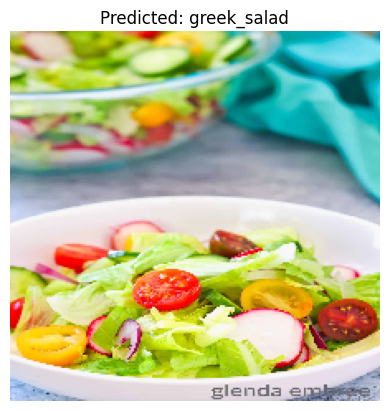

In [14]:
# Upload a new image the computer
uploaded_image = files.upload()

# Preprocess the new image
img_path = next(iter(uploaded_image))
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Predict the class of the new image
predictions = model.predict(img_array)
predicted_class = list(train_generator.class_indices.keys())[np.argmax(predictions)]

# Display the image and prediction
plt.imshow(img)
plt.title(f'Predicted: {predicted_class}')
plt.axis('off')
plt.show()
